<a href="https://colab.research.google.com/github/tebsh1/DS_Case_Study/blob/main/Tempus_DS_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview


*   Exploratory Data Analysis
*   Preprocessing
*   Feature Engineering
* Modeling
* Model Evaluation

I will be using the data present in biomarkers.csv to extract the features to train a classifier that can predict the labels in targets.csv.

**Import the necessary libraries and load our datasets.**

In [73]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploratory 
**Examine the dataset biomarkers.csv & patient_profiles.json**

In [2]:
# load and examine the data
biomarkers_df = pd.read_csv('/content/drive/MyDrive/tempus/tempus_data_science_case_study/biomarkers.csv')
biomarkers_df.head()

,biomarker_id,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,BM00007,BM00008,BM00009,BM00010,BM00011,BM00012,BM00013,BM00014,BM00015,BM00016,BM00017,BM00018,BM00019,BM00020,BM00021,BM00022,BM00023,BM00024,BM00025,BM00026,BM00027,BM00028,BM00029,BM00030,BM00031,BM00032,BM00033,BM00034,BM00035,BM00036,BM00037,BM00038,...,BM15117,BM15118,BM15119,BM15120,BM15121,BM15122,BM15123,BM15124,BM15125,BM15126,BM15127,BM15128,BM15129,BM15130,BM15131,BM15132,BM15133,BM15134,BM15135,BM15136,BM15137,BM15138,BM15139,BM15140,BM15141,BM15142,BM15143,BM15144,BM15145,BM15146,BM15147,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15154,BM15155,BM15156
0,100505de2,1,1,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,1,0,1,1,0,1,1,1,1,1,1,1,1,0,1,...,0,1,0,0,1,0,1,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,1,0,1,1,0,0,1,1.0,1,1
1,10075c5c2,1,1,1,0,0,0,1,0,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,1,0,0,...,0,1,0,0,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1,1,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,0,1,NaN,1,1
2,10105cb22,1,1,1,0,0,0,1,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,1,1,0,1,1,0,1,1,0,1,...,0,1,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,NaN,1,1
3,101219d6e,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,1,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,1,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1.0,1,1
4,10135ad45,1,0,1,0,1,0,1,0,1,1,0,0,1,1,1,1,0,1,1,0,1,0,0,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,...,1,1,1,0,0,0,0,1,1,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1.0,1,1


In [4]:
targets_df = pd.read_csv(r"/content/drive/MyDrive/tempus/tempus_data_science_case_study/targets.csv")
targets_df.head()

,patient_id,biomarker_id,target_label
0,1002df1d3,89c43bb4,0
1,1010441f,3ae31327,0
2,101eb6af1,1d8f7bab9,0
3,10204394e,129ee8c6c,0
4,1021d329b,1b44145bd,0


**patient_profiles.json is a nested josn file. We will extract the nested data later in the code.**

In [7]:
patient_profiles_df = pd.read_json(r"/content/drive/MyDrive/tempus/tempus_data_science_case_study/patient_profiles.json")
patient_profiles_df.head()

,institution,cohort_id,patient_profiles
0,Saint Penelope Medical Center,14562556998,"[{'patient_id': '102bb8fae', 'demographics': {..."
1,"BioLab, Inc.",14562556998,"[{'patient_id': '100688fb9', 'demographics': {..."
2,University Hospital System,14562556998,"[{'patient_id': '1002df1d3', 'demographics': {..."
3,Goodfellow Research Institute,14562556998,"[{'patient_id': '104fc5e3c', 'demographics': {..."
4,Montague Hospital,14562556998,"[{'patient_id': '1010441f', 'demographics': {'..."


**Check the dimensionality shape of the data frames**

In [8]:
print(biomarkers_df.shape)
print(patient_profiles_df.shape)
print(targets_df.shape)


(1960, 15158)
(7, 3)
(1734, 3)


# Preprocessing
**Check for missing data in each of the supplied data sets**

In [9]:
print('biomarkers')
print(biomarkers_df.isnull().any())
print(biomarkers_df.isnull().sum())
print("\n")

print('targets')
print(targets_df.isnull().any())
print(targets_df.isnull().sum())
print("\n")

biomarkers
biomarker_id    False
BM00000         False
BM00001         False
BM00002         False
BM00003         False
                ...  
BM15152         False
BM15153         False
BM15154          True
BM15155         False
BM15156         False
Length: 15158, dtype: bool
biomarker_id      0
BM00000           0
BM00001           0
BM00002           0
BM00003           0
               ... 
BM15152           0
BM15153           0
BM15154         772
BM15155           0
BM15156           0
Length: 15158, dtype: int64


targets
patient_id      False
biomarker_id    False
target_label    False
dtype: bool
patient_id      0
biomarker_id    0
target_label    0
dtype: int64




In [10]:
print(biomarkers_df['BM15154'].isnull().sum())

772


**Note:** from the information above, we notice that there are 772 missing or null values under the biomarkers "BM15154" where these null vlaues should either be removed or replaced with Mean/Median.


Since the NaN missing data is about 39% of our relatively smale dataset, then we may try to replace it the Median value.

In [11]:
biomarkers_df['BM15154'] = biomarkers_df['BM15154'].replace(np.NaN, biomarkers_df['BM15154'].median())


check again for null values after applying the median value

In [12]:
print(biomarkers_df['BM15154'].isnull().sum())

0


**Check for target class inbalnce**
From the figure we can clearly see that there is a big difference between the dataset target labels where 1353 No-Disease and 381 disease.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


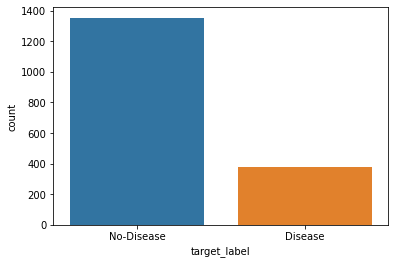

In [13]:
# visualize the target variable
g = sns.countplot(targets_df['target_label'])
g.set_xticklabels(['No-Disease','Disease'])
plt.show()

**Synthetic Minority Oversampling Technique (SMOTE)**

Due to the limited dataset, we decicded to go with oversampling technique to overcome data inbalacing.

This technique (SMOTE) generates synthetic data for the minority class by randomly picking a point from the minority class and computing the k-nearest neighbors for this point.



**But first, let's join the targets_df with biomarkers_df**

In [14]:
tr = targets_df
biomarker_patient_target = tr.merge(biomarkers_df, how='left', on="biomarker_id")
biomarker_patient_target.head(3)


,patient_id,biomarker_id,target_label,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,BM00007,BM00008,BM00009,BM00010,BM00011,BM00012,BM00013,BM00014,BM00015,BM00016,BM00017,BM00018,BM00019,BM00020,BM00021,BM00022,BM00023,BM00024,BM00025,BM00026,BM00027,BM00028,BM00029,BM00030,BM00031,BM00032,BM00033,BM00034,BM00035,BM00036,...,BM15117,BM15118,BM15119,BM15120,BM15121,BM15122,BM15123,BM15124,BM15125,BM15126,BM15127,BM15128,BM15129,BM15130,BM15131,BM15132,BM15133,BM15134,BM15135,BM15136,BM15137,BM15138,BM15139,BM15140,BM15141,BM15142,BM15143,BM15144,BM15145,BM15146,BM15147,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15154,BM15155,BM15156
0,1002df1d3,89c43bb4,0,1,1,1,1,0,0,0,0,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,0,1,0,0,1,0,0,1,1,1,1,...,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,1.0,1,1
1,1010441f,3ae31327,0,0,1,1,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,1,0,1,...,0,1,0,0,1,0,0,1,1,1,0,0,1,1,0,1,0,0,1,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1.0,1,1
2,101eb6af1,1d8f7bab9,0,1,1,1,1,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,1,1,1,...,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1,0,1,0,0,0,1,1.0,1,1


Chech the new shape of the data frame and if there is any null value

In [24]:
print(tr.shape)
print(biomarkers_df.shape)
print(biomarker_patient_target.shape)

print('biomarkers_targets')
print(biomarker_patient_target.isnull().any())
print(biomarker_patient_target.isnull().sum())
print("\n")

print('target id')
print(biomarker_patient_target['target_label'].isnull().any())
print(biomarker_patient_target['target_label'].isnull().sum())
print("\n")
biomarker_patient_target['BM15154'] = biomarker_patient_target['BM15154'].astype('int64')
#biomarker_patient_target['BM15154']
biomarker_patient_target.dtypes

(1734, 3)
(1960, 15158)
(1038, 15160)
biomarkers_targets
patient_id      False
biomarker_id    False
target_label    False
BM00000         False
BM00001         False
                ...  
BM15152         False
BM15153         False
BM15154         False
BM15155         False
BM15156         False
Length: 15160, dtype: bool
patient_id      0
biomarker_id    0
target_label    0
BM00000         0
BM00001         0
               ..
BM15152         0
BM15153         0
BM15154         0
BM15155         0
BM15156         0
Length: 15160, dtype: int64


target id
False
0




patient_id      object
biomarker_id    object
target_label     int64
BM00000          int64
BM00001          int64
                 ...  
BM15152          int64
BM15153          int64
BM15154          int64
BM15155          int64
BM15156          int64
Length: 15160, dtype: object

In [25]:
#biomarker_patient_target.head(3)
# Check for missing data in each of the supplied data sets
print('biomarker_patient_target')
biomarker_patient_target.dropna(inplace=True)
print(biomarker_patient_target.isnull().sum())
print("\n")


biomarker_patient_target
patient_id      0
biomarker_id    0
target_label    0
BM00000         0
BM00001         0
               ..
BM15152         0
BM15153         0
BM15154         0
BM15155         0
BM15156         0
Length: 15160, dtype: int64




# Feature Engineering

Based on the the analysis above, we will extract the features of the biomarkers to train a classifier to predict target labels.

In [26]:
# biomarker_patient_target = biomarker_patient_target.reset_index()
X = biomarker_patient_target.drop(['biomarker_id' ,'target_label', 'patient_id'], axis= 1)
y = biomarker_patient_target['target_label']
y.head
X.head

<bound method NDFrame.head of       BM00000  BM00001  BM00002  BM00003  ...  BM15153  BM15154  BM15155  BM15156
0           1        1        1        1  ...        1        1        1        1
1           0        1        1        0  ...        1        1        1        1
3           1        1        1        1  ...        1        1        1        1
4           1        1        1        1  ...        1        1        1        1
7           1        1        0        0  ...        1        1        1        1
...       ...      ...      ...      ...  ...      ...      ...      ...      ...
1721        0        1        0        0  ...        1        1        1        1
1724        1        1        1        0  ...        1        1        1        1
1726        1        1        1        0  ...        1        1        1        1
1727        1        1        1        0  ...        1        1        1        1
1729        0        1        0        0  ...        1        1     

# Modeling


**Import ML Models**

In [54]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
# from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from tqdm import tqdm
from sklearn import datasets, linear_model
from sklearn.model_selection import  train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


**List of ML models to be trained and tested**

In [55]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

***Model training - testing Function ***

In [66]:
def modeling(X, y, ml_models):
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)
  names = []
  scores = []
  for name, model in tqdm(ml_models):
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      scores.append(accuracy_score(y_test, y_pred))
      names.append(name)
  tr_info = pd.DataFrame({'Model': names, 'Score': scores})
  return tr_info


**Visualization of Model Scores**

In [69]:
def visualize_scores(train_info):
  axis = sns.barplot(x = 'Model', y = 'Score', data = train_info, palette='Blues_d')
  axis.set(xlabel='Classifier', ylabel='Accuracy')
  for p in axis.patches:
      height = p.get_height()
      axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
  plt.show()

**Let's train and test our model using feature without (SMOTE)**

In [67]:
train_info = modeling(X, y, models)
print(train_info)

 29%|██▊       | 2/7 [00:29<00:58, 11.75s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
100%|██████████| 7/7 [01:12<00:00, 10.43s/it]

  Model     Score
0   KNN  0.701923
1   SVC  0.774038
2    LR  0.774038
3    DT  0.807692
4   GNB  0.514423
5    RF  0.774038
6    GB  0.894231


We can notice the perfromance of the machine learning model is quiet poor due to dataset inbalance, while the best score is for 'GB' Gradient Boosting Classifier. This is expected to improve when we apply oversampling techinique (SMOTE)

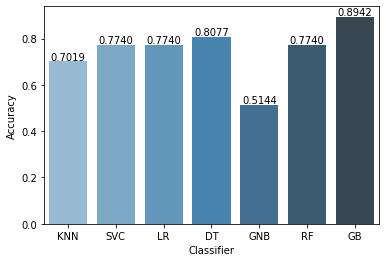

In [70]:
# Visualize model model scores
visualize_scores(train_info)

Now, we apply (SMOTE) oversampling to balance out the classes


In [43]:
# import library
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0: 812, 1: 226})
Resample dataset shape Counter({0: 812, 1: 812})


**Visualize the distribution of the enhanced target class**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


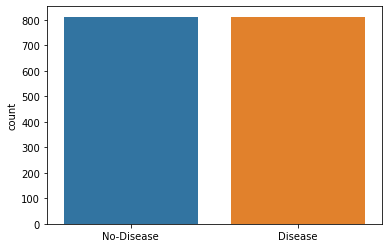

In [51]:
g = sns.countplot(y_smote)
g.set_xticklabels(['No-Disease','Disease'])
plt.show()

**Retrain our models after using (SMOTE)**

In [72]:
train_info = modeling(x_smote, y_smote, models)
print(train_info)


 29%|██▊       | 2/7 [01:04<02:11, 26.27s/it]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

100%|██████████| 7/7 [04:26<00:00, 38.04s/it]

  Model     Score
0   KNN  0.455385
1   SVC  0.935385
2    LR  0.978462
3    DT  0.876923
4   GNB  0.643077
5    RF  0.880000
6    GB  0.938462


**` Visualize Model Scores`**

As we can see, the perfromance of the models has greatly improved for most models, where the highest score is for "LR" Logistic Regression Classifier.

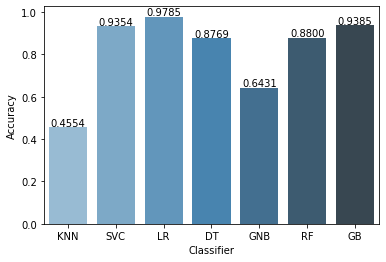

In [74]:
# Visualize model model scores
visualize_scores(train_info)

# Model Evaluation
**Let's take closer look at LogisticRegression model**

In [81]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

LR_model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(x_smote,y_smote, test_size = 0.2, random_state=42)
LR_model.fit(X_train,y_train)

prediction = LR_model.predict(X_test)

accuracy = accuracy_score(y_test, prediction)

print ("Accuracy of our Logistic Regression model is: {0:0.4f}".format(accuracy))
print("\n")

Accuracy of our Logistic Regression model is: 0.9785




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**Confusion Matrix**

In [85]:
print ("Confusion Matrix")

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(confusion_matrix(y_test, prediction, labels=[1, 0])))
cmx = confusion_matrix(y_test, prediction)

Confusion Matrix
[[143   5]
 [  2 175]]


**Classification Report**

In [88]:
print ("Classification Report")

# labels for set 1=True to upper left and 0 = False to lower right
print ("{0}".format(classification_report(y_test, prediction, labels=[1, 0])))

Classification Report
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       148
           0       0.97      0.99      0.98       177

    accuracy                           0.98       325
   macro avg       0.98      0.98      0.98       325
weighted avg       0.98      0.98      0.98       325

